<a href="https://colab.research.google.com/github/GerardoFesta/3DFER_SE4AI/blob/main/models/3DModels/DistanceCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and unzip of the data

In [ ]:
!pip install mediapipe

In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Change the path for your dataset

In [ ]:
import zipfile


zip_ref = zipfile.ZipFile('/content/drive/Shareddrives/Datasets SEFAI/fer2013.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall() #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
import plotly.express as px
import cv2
import mediapipe as mp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import linspace
from mpl_toolkits import mplot3d
import glob, os
import json
import pandas as pd
import math

# Dataset Creation from the connections

Here we get the list of connections

In [ ]:
mp_face_mesh = mp.solutions.face_mesh

contour_list = [landmark_tuple for landmark_tuple in mp_face_mesh.FACEMESH_CONTOURS]
tass_list = [landmark_tuple for landmark_tuple in mp_face_mesh.FACEMESH_TESSELATION]
irises_list = [landmark_tuple for landmark_tuple in mp_face_mesh.FACEMESH_IRISES]
all_links_list = list(set(contour_list) | set(tass_list) | set(irises_list))
all_links_array = np.array(all_links_list)

Here we load the landmarks from the csv

In [ ]:
train_df = pd.read_csv("/content/drive/Shareddrives/Datasets SEFAI/training_set.csv")
test_df = pd.read_csv("/content/drive/Shareddrives/Datasets SEFAI/test_set.csv")
test_df['landmarks'] = test_df['landmarks'].apply(lambda lab: eval(lab))

train_df['landmarks'] = train_df['landmarks'].apply(lambda lab: eval(lab))
print(len(train_df))
print(len(test_df))

26705
6678


Here we calculate the distance between the landmarks that are actually connected for training and test set

In [ ]:
train_dataset = np.empty(shape= (len(train_df),2626))
for i in range(len(train_df)):
  landmarks = train_df.iloc[i]["landmarks"]
  for j, couple in enumerate(all_links_array):
    x2 = landmarks[couple[1]][0]
    x1 = landmarks[couple[0]][0]
    y2 = landmarks[couple[1]][1]
    y1 = landmarks[couple[0]][1]
    z2 = landmarks[couple[1]][2]
    z1 = landmarks[couple[0]][2]
    distance =  math.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    train_dataset[i][j] = distance


In [ ]:
test_dataset = np.empty(shape= (len(test_df),2626))
for i in range(len(test_df)):
  landmarks = test_df.iloc[i]["landmarks"]
  for j, couple in enumerate(all_links_array):
    x2 = landmarks[couple[1]][0]
    x1 = landmarks[couple[0]][0]
    y2 = landmarks[couple[1]][1]
    y1 = landmarks[couple[0]][1]
    z2 = landmarks[couple[1]][2]
    z1 = landmarks[couple[0]][2]
    distance =  math.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    test_dataset[i][j] = distance

In [ ]:

label_dict = {"angry":0, "sad": 1, "neutral": 2, "surprise": 3, "disgust": 4, "fear": 5, "happy": 6}
test_df['label'] = test_df['label'].apply(lambda lab: label_dict[lab])

train_df['label'] = train_df['label'].apply(lambda lab: label_dict[lab])

y_test = test_df['label'].to_numpy()
y_train = train_df['label'].to_numpy()

In [ ]:
np.savez('distance_test_dataset.npz', data=test_dataset, labels=y_test)
np.savez('distance_train_dataset.npz', data=train_dataset, labels=y_train)

# Checkpoint to reload data


In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Do not execute this if you don't want to log on mlflow

In [ ]:
!pip install -q mlflow
!databricks configure --host https://community.cloud.databricks.com/

Dataset and dataloader ahead

In [ ]:
from torch.utils.data import Dataset
import numpy as np
class CustomDataset(Dataset):
    def __init__(self, X_array, Y_array, transform=None):
        self.X = X_array
        self.Y = Y_array
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        image = self.X[index]
        label = self.Y[index]

        # Esegui le trasformazioni se definite
        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import torch
train_df = np.load('/content/drive/Shareddrives/Datasets SEFAI/distance_train_dataset.npz')
test_df = np.load('/content/drive/Shareddrives/Datasets SEFAI/distance_test_dataset.npz')

X_train= train_df['data']
X_test = test_df['data']
y_train = train_df['labels']
y_test = test_df['labels']

train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))

test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))


# Distance CNN

In [ ]:

def accuracy(preds, labels):
  probabilities = torch.nn.functional.softmax(preds, dim=1)
  _, predicted = torch.max(probabilities, dim=1)
  n_correct = (predicted==labels).sum().float()

  acc =n_correct / labels.shape[0]
  acc= torch.round(acc*100)
  return acc, n_correct;

In [ ]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(128 * 326, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 7)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.relu(x)

        x = self.fc3(x)
        return x



# Training Loop

Do not execute if you don't want to log on mlflow

In [ ]:
import mlflow
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/gfesta24@gmail.com/DistanceCNN")

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/531884495140798', creation_time=1688071348937, experiment_id='531884495140798', last_update_time=1688075470252, lifecycle_stage='active', name='/Users/gfesta24@gmail.com/DistanceCNN', tags={'mlflow.experiment.sourceName': '/Users/gfesta24@gmail.com/DistanceCNN',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'gfesta24@gmail.com',
 'mlflow.ownerId': '1923923806180228'}>

Grid Search and early stopping in place, comment or modify the mlflow lines

In [ ]:
from sklearn.model_selection import ParameterGrid
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

param_grid = {'batch_size': [64, 128, 256, 512],'lr': [0.0001, 0.001], "decay":[0, 0.001, 0.01]}
expanded_grid = ParameterGrid(param_grid)
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name("/Users/gfesta24@gmail.com/DistanceCNN")

for i in range(len(expanded_grid)):

  runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id], filter_string=" and ".join([f"params.{k} = '{v}'" for k, v in expanded_grid[i].items()]))
  if not len(runs) == 0:
    print("RUN: ", [f"params.{k} = '{v}'" for k, v in expanded_grid[i].items()], " già completata" )
  else:
    train_loader = DataLoader(train_dataset, batch_size=expanded_grid[i]['batch_size'], shuffle=True)

    test_loader = DataLoader(test_dataset, batch_size=expanded_grid[i]['batch_size'], shuffle=False)

    model = CNN()
    optimizer = optim.Adam(model.parameters(), lr=expanded_grid[i]['lr'], weight_decay=expanded_grid[i]['decay'])
    criterion = nn.CrossEntropyLoss()
    model.to(device)

    mlflow.start_run()

    mlflow.set_tag("model_name", "3LayerCNN")
    mlflow.log_param("lr", expanded_grid[i]['lr'])
    mlflow.log_param("batch_size", expanded_grid[i]['batch_size'])
    mlflow.log_param("decay", expanded_grid[i]['decay'])

    patience=3
    counter = 0
    stop = False

    # Training loop
    best_accuracy = 0.0
    best_loss = 1000

    for epoch in range(100):
      print(counter)
      if stop:
        print(stop)
        break
      model.train()
      running_loss = 0.0
      running_acc = 0
      tot_seen = 0
      for X_batch, y_batch in train_loader:
        X_batch=X_batch.unsqueeze(1)
        X_batch = X_batch.type(torch.cuda.FloatTensor)
        y_batch = y_batch.long()
        #manda i batch al device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        #azzera gradiente
        optimizer.zero_grad()
        #predict
        y_pred = model(X_batch)


        #print(y_batch.shape)
        loss = criterion(y_pred, y_batch)
        _,acc = accuracy(y_pred, y_batch)
        #backpropagation della loss
        loss.backward()
        #ottimizzazione
        optimizer.step()

        #somma della loss e dell'accuracy per il batch
        running_loss += loss.item()
        running_acc += acc
        tot_seen += len(y_batch)

      train_accuracy = running_acc/tot_seen
      train_loss = running_loss / len(train_loader)
      print(f'Epoch {epoch}: | Loss: {train_loss:.5f} | Acc: {running_acc/tot_seen:.3f}')
      mlflow.log_metric("train_loss", train_loss, step=epoch)
      mlflow.log_metric("train_acc", train_accuracy, step=epoch)
      model.eval()

      tot_corrette = 0
      tot_eseguite = 0
      running_test_loss = 0
      val_loss = 0

      with torch.no_grad():

        for images, labels in test_loader:
            images=images.unsqueeze(1)
            images = images.to(device)
            labels = labels.long()
            labels = labels.to(device)

            outputs = model(images)
            test_loss = criterion(outputs, labels)
            _, n_corrette=accuracy(outputs, labels)

            running_test_loss += test_loss.item()
            tot_corrette+=n_corrette.item()
            tot_eseguite+=labels.shape[0]

        test_acc=100* (tot_corrette/tot_eseguite)
        test_loss = running_test_loss / len(test_loader)
        print("Test acc: ", test_acc)
        print("Test loss: ", test_loss)
        mlflow.log_metric("test_acc", test_acc, step=epoch)
        mlflow.log_metric("test_loss", test_loss, step=epoch)

        if test_loss < best_loss:
              print("MIGLIORATO")
              torch.save(model.state_dict(), 'model_weights.pth')
              best_loss = test_loss
              best_model_train_acc=train_accuracy
              best_model_test_acc=test_acc
              best_model_test_loss=test_loss
              best_model_train_loss=running_loss / len(train_loader)
              counter = 0
              # Salva i pesi del modello se la validation loss è migliorata
              torch.save(model.state_dict(), 'best_model.pt')
        else:
            counter += 1
            # Verifica se raggiunto il criterio di early stopping
            if counter >= patience:
                  print(f'Early stopping at epoch {epoch+1}')
                  mlflow.set_tag("Epochs_stopped", epoch+1)
                  mlflow.log_artifact("best_model.pt")
                  mlflow.log_metric("best_test_acc", best_model_test_acc)
                  mlflow.log_metric("best_test_loss", best_model_test_loss)
                  mlflow.log_metric("best_train_acc", best_model_train_acc)
                  mlflow.log_metric("best_train_loss", best_model_train_loss)
                  mlflow.end_run()
                  stop=True
        print("BEST TEST LOSS: ", best_loss)




0
Epoch 0: | Loss: 1.80826 | Acc: 0.260
Test acc:  25.666367175801135
Test loss:  1.8039232605979556
MIGLIORATO
BEST TEST LOSS:  1.8039232605979556
0
Epoch 1: | Loss: 1.80370 | Acc: 0.260
Test acc:  25.666367175801135
Test loss:  1.8047355504263014
BEST TEST LOSS:  1.8039232605979556
1
Epoch 2: | Loss: 1.80280 | Acc: 0.260
Test acc:  25.666367175801135
Test loss:  1.800826300893511
MIGLIORATO
BEST TEST LOSS:  1.800826300893511
0
Epoch 3: | Loss: 1.79882 | Acc: 0.260
Test acc:  25.666367175801135
Test loss:  1.788718741280692
MIGLIORATO
BEST TEST LOSS:  1.788718741280692
0
Epoch 4: | Loss: 1.68414 | Acc: 0.317
Test acc:  34.17190775681342
Test loss:  1.6107831969147637
MIGLIORATO
BEST TEST LOSS:  1.6107831969147637
0
Epoch 5: | Loss: 1.52761 | Acc: 0.404
Test acc:  42.108415693321355
Test loss:  1.4993064448946998
MIGLIORATO
BEST TEST LOSS:  1.4993064448946998
0
Epoch 6: | Loss: 1.46716 | Acc: 0.427
Test acc:  43.06678646301288
Test loss:  1.4608079893248422
MIGLIORATO
BEST TEST LOSS:  

# Testing

This gets the best model

In [ ]:
def get_artifact_with_lowest_metric(experiment_id, metric_name, artifact_name):
    runs = mlflow.search_runs(experiment_ids=[experiment_id]).sort_values(f"{metric_name}")
    lowest_metric_run = runs.iloc[0]

    run_id = lowest_metric_run.run_id
    artifact_uri = mlflow.get_artifact_uri(run_id)

    artifact_path = f"{artifact_uri}/{artifact_name}"
    return run_id, artifact_path

# Specifica l'ID del tuo esperimento e i nomi delle metrica e dell'artefatto
experiment_id = '531884495140798'
metric_name = 'metrics.best_test_loss'
artifact_name = 'model_weights'

run_id, artifact_path = get_artifact_with_lowest_metric(experiment_id, metric_name, artifact_name)

print("Artifatto 'model_weights' nella run con la metrica 'best_test_acc' più bassa:")
print(artifact_path)

Artifatto 'model_weights' nella run con la metrica 'best_test_acc' più bassa:
dbfs:/databricks/mlflow-tracking/531884495140798/fe77b8da414a4d2c95264983d56959c0/artifacts/b1ced073889546f9a3e3c5a78023f384/model_weights


In [ ]:
mlflow.artifacts.download_artifacts(run_id=run_id, dst_path="/content/artefatto")

'/content/artefatto/'

Processing and metrics extraction on the test set

Test Metrics:
Accuracy: 0.5729260257562144
Precision: [0.42487562 0.44300518 0.52725793 0.64537445 0.4        0.37398374
 0.78140032]
F1 Score: [0.45963402 0.45298013 0.53686827 0.69390172 0.10714286 0.25680391
 0.81562064]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.42      0.50      0.46       853
         1.0       0.44      0.46      0.45      1107
         2.0       0.53      0.55      0.54      1185
         3.0       0.65      0.75      0.69       781
         4.0       0.40      0.06      0.11        97
         5.0       0.37      0.20      0.26       941
         6.0       0.78      0.85      0.82      1714

    accuracy                           0.57      6678
   macro avg       0.51      0.48      0.47      6678
weighted avg       0.56      0.57      0.56      6678



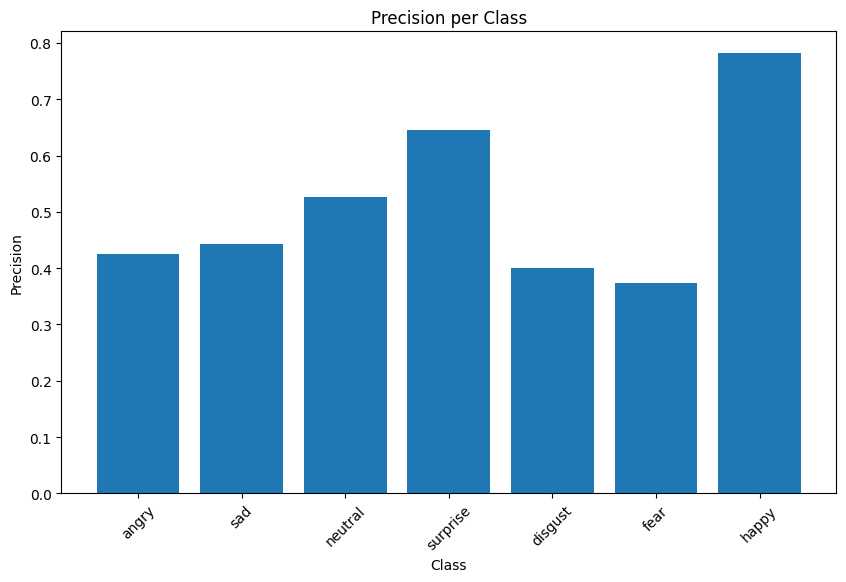

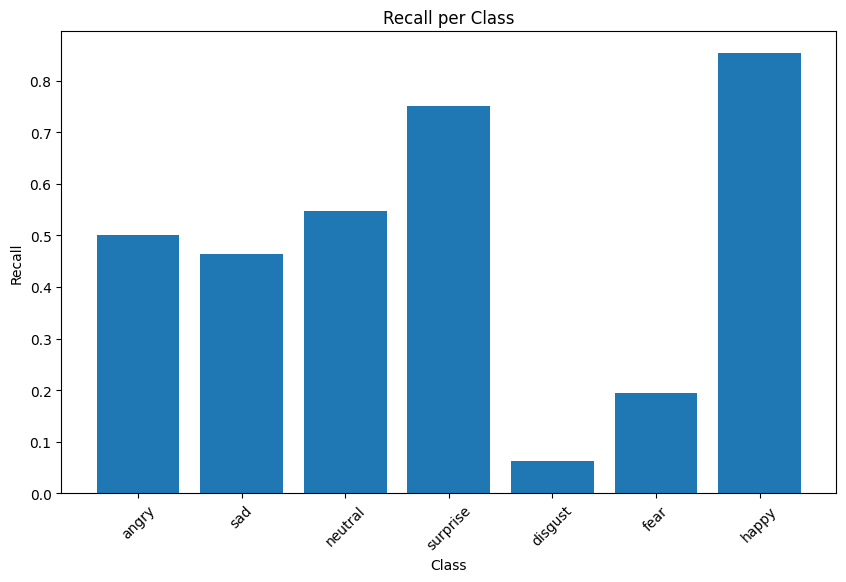

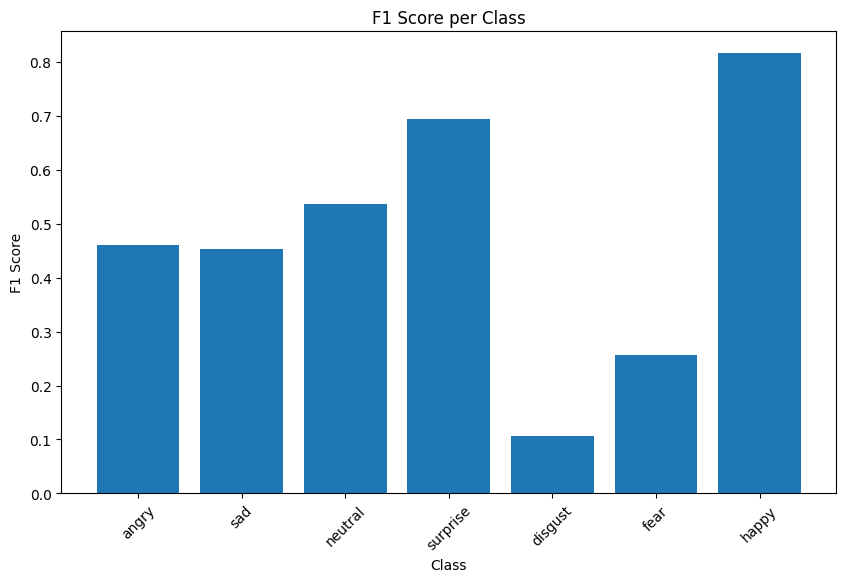

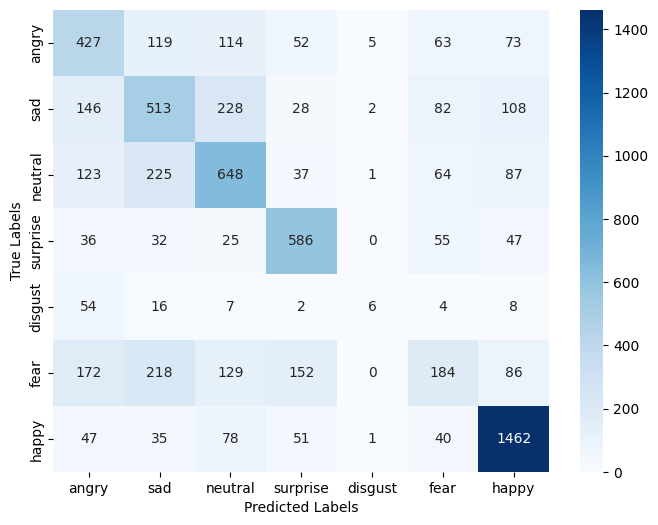

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

model = CNN()
model.load_state_dict(torch.load("/content/artefatto/best_model.pt"))
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)



# Calcola le metriche sul test dataset
model.eval()  # Imposta il modello in modalità di valutazione (non addestramento)
test_predictions = []
test_labels = []
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

with torch.no_grad():
    for images, labels in test_loader:
        images=images.unsqueeze(1)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(torch.nn.functional.softmax(outputs, dim=1), 1)
        test_predictions.extend(predictions.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())


accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions, average=None)
recall = recall_score(test_labels, test_predictions, average=None)
f1 = f1_score(test_labels, test_predictions, average=None)
#auc_roc = roc_auc_score(test_labels, test_predictions, multi_class='ovr')
classification_rep = classification_report(test_labels, test_predictions)

print("Test Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
#print("AUC-ROC:", auc_roc)
print("Classification Report:\n", classification_rep)

# Lista delle etichette delle classi
#class_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6']
class_labels=[9,9,9,9,9,9,9]
label_dict = {"angry":0, "sad": 1, "neutral": 2, "surprise": 3, "disgust": 4, "fear": 5, "happy": 6}
for label in ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]:
  class_labels[label_dict[label]]=label




# Crea il grafico a barre per la precisione
plt.figure(figsize=(10, 6))
plt.bar(class_labels, precision)
plt.title('Precision per Class')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.xticks(rotation=45)
plt.show()

# Crea il grafico a barre per il recall
plt.figure(figsize=(10, 6))
plt.bar(class_labels, recall)
plt.title('Recall per Class')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.xticks(rotation=45)
plt.show()

# Crea il grafico a barre per l'F1-score
plt.figure(figsize=(10, 6))
plt.bar(class_labels, f1)
plt.title('F1 Score per Class')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.show()


# Calcola la matrice di confusione
cm = confusion_matrix(test_labels, test_predictions)

# Crea una figura e un'asse per la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Imposta i nomi delle etichette sulle assi x e y
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")


# Visualizza la matrice di confusione
plt.show()
